# Comparer QLearning tabulaire et DQN sur quelques environnements

### Partie 1 : QLearning Tabulaire

Ci-dessous, une implémentation du QLearning tabulaire.

In [2]:
import numpy as np

def train_q_learning(env, alpha = 0.1, gamma = 0.9, epsilon = 0.1, episodes = 100) :
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rewards = []
    
    
    for episode in range(episodes) :
        state = env.reset()
        total_reward = 0
        done = False
        while not done :
            if np.random.rand() < epsilon :
                action = np.random.choice(range(n_actions))
            else :
                action = np.argmax(Q[state])
            next_state, reward, done, _ = env.step(action)
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    
    return Q, rewards

### Partie 2 : DQN

Ci-dessous, les méthodes pour entraînement et test DQN en utilisant stableBaseLines3

In [3]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback



# === CALLBACK POUR LOGGER LES RÉCOMPENSES ===
class RewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.current_rewards = 0

    def _on_step(self):
        self.current_rewards += self.locals["rewards"][0]
        if self.locals["dones"][0]:
            self.episode_rewards.append(self.current_rewards)
            self.current_rewards = 0
        return True

# === ENTRAÎNEMENT DQN ===
def train_dqn(env, lr = 0.01, buffer_size = 500, 
              exploration_fraction = 0.3, exploration_final_eps = 0.05, 
              timesteps = 2000):
    
    env = make_vec_env(lambda: env, n_envs=1)
    logger = RewardLogger()

    model = DQN(
        "MlpPolicy",
        env,
        verbose=0,
        learning_rate=lr,
        buffer_size=buffer_size,
        train_freq=1,
        target_update_interval=10,
        exploration_fraction=exploration_fraction,
        exploration_final_eps=exploration_final_eps,
    )

    model.learn(total_timesteps=timesteps, callback=logger)

    return model, logger.episode_rewards

# === TEST DU MODÈLE ===
def test_dqn(env, model):
    env = env
    obs = env.reset()
    print("\nTest du modèle entraîné :")
    trajectory = [obs]
    for _ in range(40):
        action = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        trajectory.append(obs)
        env.render()
        if done:
            break
    print("Trajectoire :", " → ".join(map(str, trajectory)))

### Partie 3 : Environnement LineWorld


Nous avons un couloir de taille n représenté par un array.
L'agent commence tout à gauche, et doit traverser le couloir pour arriver à droite.

Il peut soit se déplacer à gauche soit se déplacer à droite.

In [4]:
import gym
from gym import spaces

class LineWorldEnv(gym.Env):
    def __init__(self, n_states=3):
        super(LineWorldEnv, self).__init__()
        self.n_states = n_states
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(n_states)
        self.state = 0

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        if action == 0 and self.state > 0:
            self.state -= 1
        elif action == 1 and self.state < self.n_states - 1:
            self.state += 1
        done = self.state == self.n_states - 1
        reward = 10 if done else -1
        return self.state, reward, done, {}

    def render(self, mode='human'):
        print("État actuel :", self.state)
    
    def seed(self, seedInt) :
        # environnement deterministe, methode necessaire pour stablebaseline
        pass

### Partie 4 : Environnement FrozenLake

Voir https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [5]:
import gymnasium
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


class FrozenLakeEnv(gym.Env) :
    def __init__(self, lake_map = generate_random_map(size=4)) :
        super(FrozenLakeEnv, self).__init__()
        self.size = len(lake_map)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(size ** 2)
        self.state = 0
        self.map = lake_map
    
    def reset(self) :
        self.state = 0
        return self.state
    
    def step(self, action) :
        x, y = self._stateToCoordinate(self.state)
        if action == 0 : # Left
            if x > 0 :
                x -= 1
        elif action == 1 : # Down
            if y < self.size -1 :
                y += 1
        elif action == 2 : # Right
            if x < self.size -1 :
                x += 1
        elif action == 3 : # Up
            if y > 0 :
                y -= 1
        
        self.state = self._coordinateToState(x, y)
        
        result = self.map[y][x]
        done = result in ['H', 'G']
        reward = 1 if result == 'G' else 0
        return self.state, reward, done, {}
    
    
    def _stateToCoordinate(self, state) :
        x = state % self.size
        y = state // self.size
        return x, y
    
    def _coordinateToState(self, x, y) :
        return self.size*y + x
    
    def render(self, mode='human') :
        x, y = self._stateToCoordinate(self.state)
        toPrint = ''
        for i in range(self.size) :
            toPrintRow = ''
            row = self.map[i]
            for j in range(self.size) :
                if (j, i) == (x, y):
                    toPrintRow += '.'
                else :
                    toPrintRow += row[j]
            toPrint += toPrintRow + '\n'
        print(toPrint)
        
    def seed(self, seedInt):
        pass
        #determinist, needed for stablebaselines3

## Observations

### 1. Comparaison convergence vers solution optimale LineWorld

On sait que la récompense obtenue au bout du couloir est de 10
Et que pour tout autre action la récompense maximale est de 1

Ainsi la récompense optimale obtensible pour un couloir de taille n >= 3 est de 12-n


Nous pouvons afficher le point (12-taille_couloir) - recompense afin que l'axe des abscisses représente la récompense maximale obtensible pour l'environnement donné.

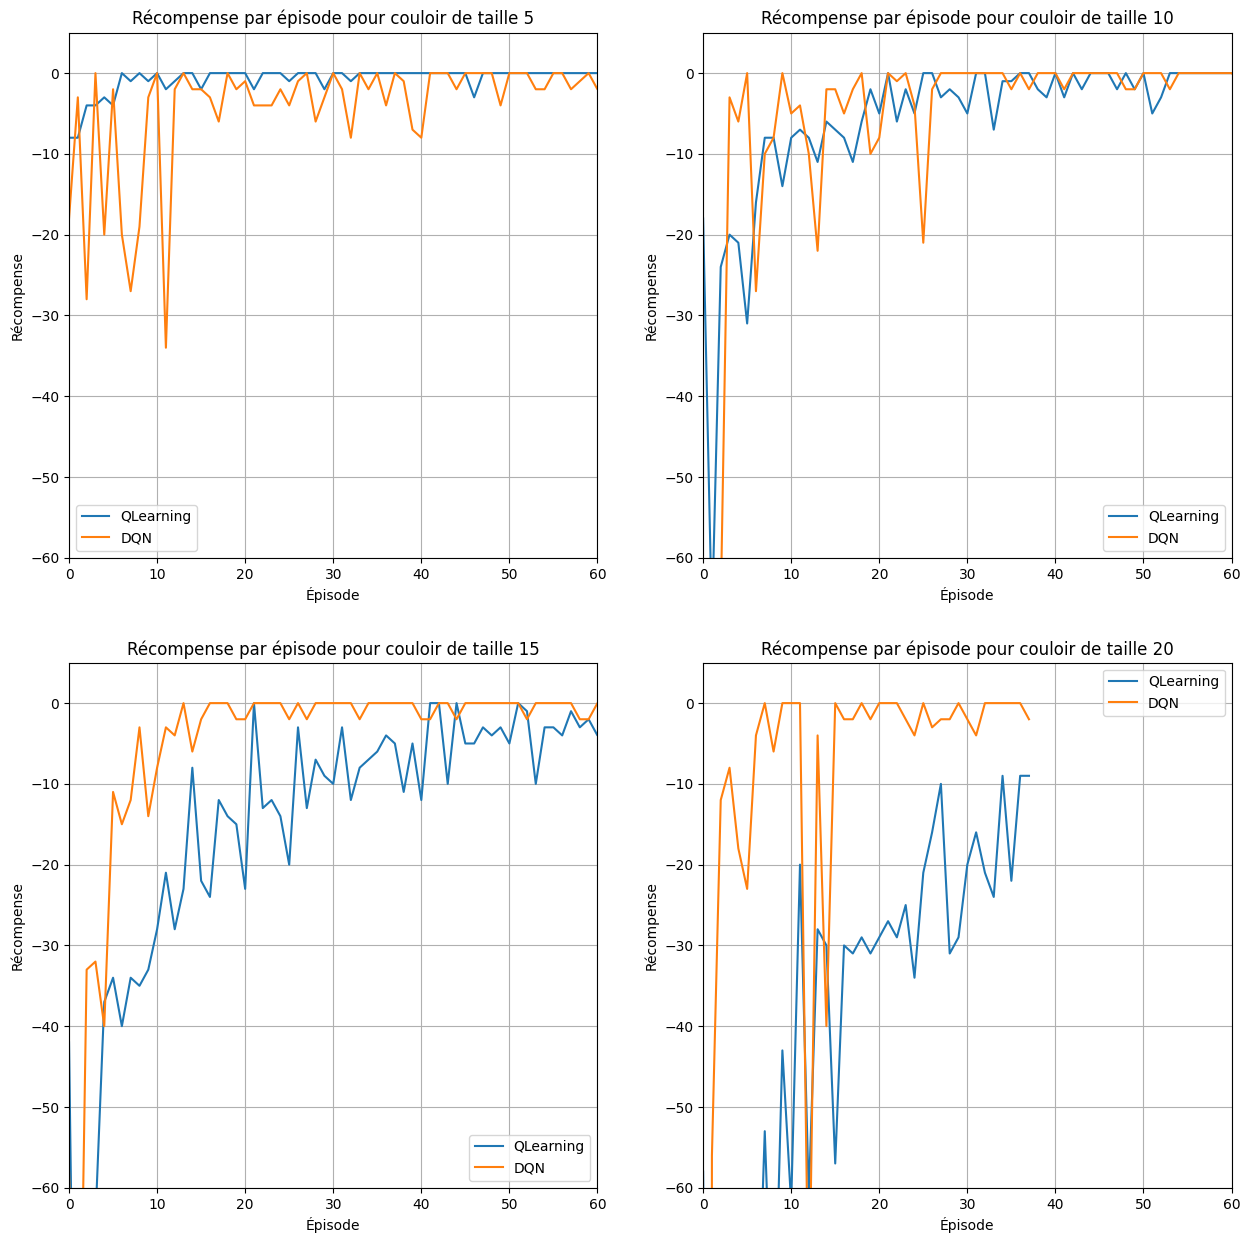

In [168]:
import matplotlib.pyplot as plt

data = [(5, 0, 0), (10, 0, 1), (15, 1, 0), (20, 1, 1)]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))


for (n_states, x, y) in data :
    env = LineWorldEnv(n_states)
    
    DQNmodel, DQNrewards = train_dqn(env)
    QTable, QRewards = train_q_learning(env, episodes = len(DQNrewards))
    
    
    axes[x, y].plot([r - (12-n_states) for r in QRewards], label='QLearning')
    axes[x, y].plot([r - (12-n_states) for r in DQNrewards], label='DQN')
    axes[x, y].set_xlim([0, 60])
    axes[x, y].set_ylim([-60, 5])
    axes[x, y].legend()
    axes[x, y].set_xlabel("Épisode")
    axes[x, y].set_ylabel("Récompense")
    axes[x, y].set_title(f"Récompense par épisode pour couloir de taille {n_states}")
    axes[x, y].grid()
plt.show()

Nous remarquons que la méthode tabulaire est plus efficace lorsque que le couloir est de taille limitée.
Néanmoins lorsque la taille du couloir grandit, la méthode faisaint usage d'un réseau à la place d'un tableau semble plus adaptée.

### 2. Observation FrozeLake non slippery

/home/thewalder/Documents/Stage/Dépôts/pourvu/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


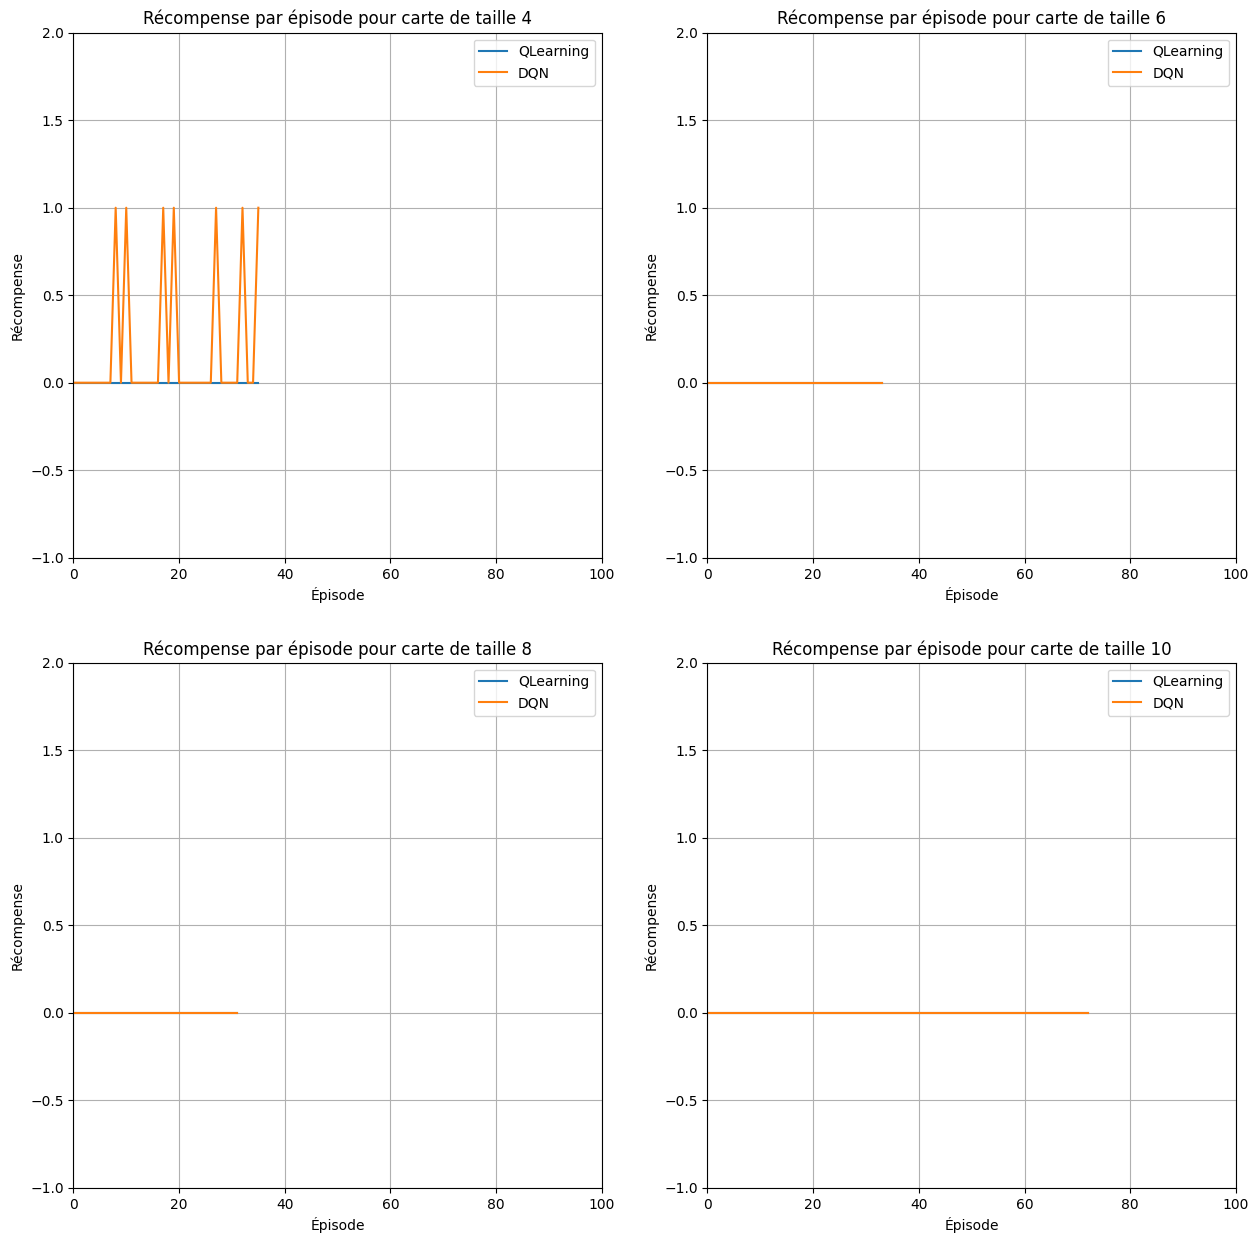

In [7]:
import matplotlib.pyplot as plt

data = [(4, 0, 0), (6, 0, 1), (8, 1, 0), (10, 1, 1)]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))


for (size, x, y) in data :
    lake_map = generate_random_map(size = size)
    env = FrozenLakeEnv(lake_map = lake_map)
    
    DQNmodel, DQNrewards = train_dqn(env)
    QTable, QRewards = train_q_learning(env, episodes = len(DQNrewards))
    
    
    axes[x, y].plot([r for r in QRewards], label='QLearning')
    axes[x, y].plot([r for r in DQNrewards], label='DQN')
    axes[x, y].set_xlim([0, 100])
    axes[x, y].set_ylim([-1, 2])
    axes[x, y].legend()
    axes[x, y].set_xlabel("Épisode")
    axes[x, y].set_ylabel("Récompense")
    axes[x, y].set_title(f"Récompense par épisode pour carte de taille {size}")
    axes[x, y].grid()
plt.show()